In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# STEP 1: Load CSV files
# =======================
train_csv = pd.read_csv("Training_set.csv")
test_csv = pd.read_csv("Testing_s" \
"" \
"" \
"et.csv")

print("✅ Training data shape:", train_csv.shape)
print("✅ Testing data shape:", test_csv.shape)
print(train_csv.head())

# If the CSV has columns like 'filename' and 'label', check them
print("Columns:", train_csv.columns)


✅ Training data shape: (6499, 2)
✅ Testing data shape: (2786, 1)
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
Columns: Index(['filename', 'label'], dtype='object')


In [42]:
train_dir = "train"
test_dir = "test"

print("Checking folders...")
print("Train folder exists:", os.path.exists(train_dir))
print("Test folder exists:", os.path.exists(test_dir))


Checking folders...
Train folder exists: True
Test folder exists: True


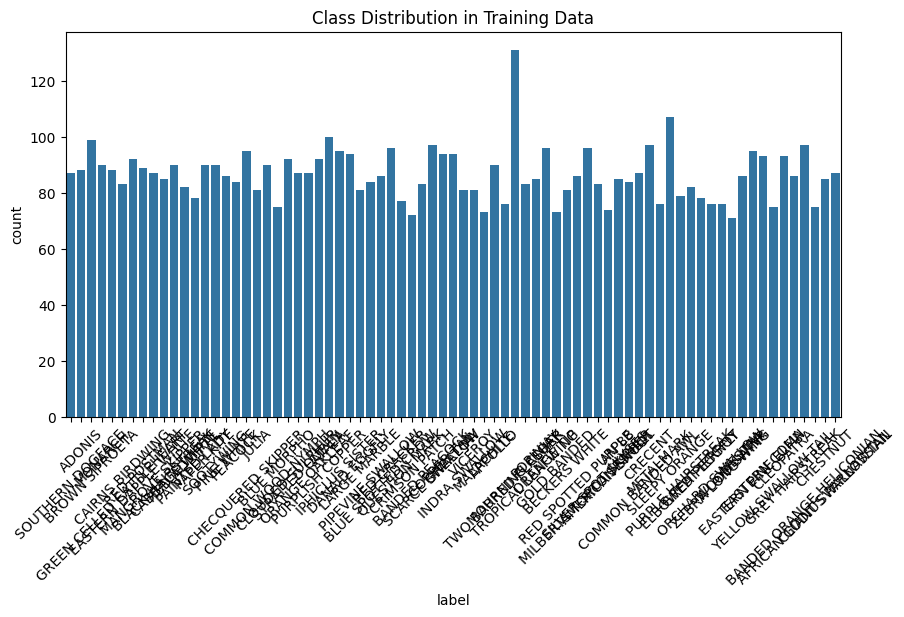

Total unique classes: 75


In [43]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=train_csv)
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=45)
plt.show()

print("Total unique classes:", train_csv['label'].nunique())


In [44]:
# STEP 5: Image Generators
# ========================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    subset='training',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    subset='validation',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=test_dir,
    x_col='filename',
    target_size=(128,128),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


In [46]:
# STEP 6: Build CNN Model
# ========================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Use class_indices length instead of num_classes
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,314,315 (12.64 MB)

 Trainable params: 3,314,315 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# ========================
# STEP 7: Train the Model
# ========================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 199ms/step - accuracy: 0.8112 - loss: 0.6000 - val_accuracy: 0.5982 - val_loss: 1.7179
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.8196 - loss: 0.5482 - val_accuracy: 0.5951 - val_loss: 1.7552
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.8421 - loss: 0.4837 - val_accuracy: 0.6074 - val_loss: 1.7244
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.8531 - loss: 0.4611 - val_accuracy: 0.5989 - val_loss: 1.7900
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.8598 - loss: 0.4338 - val_accuracy: 0.5943 - val_loss: 1.8350
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.8713 - loss: 0.3989 - val_accuracy: 0.6028 - val_loss: 1.8178
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.8890 - loss: 0.3510 - val_accuracy: 0.5958 - val_loss: 1.8761
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.8950 - loss: 0

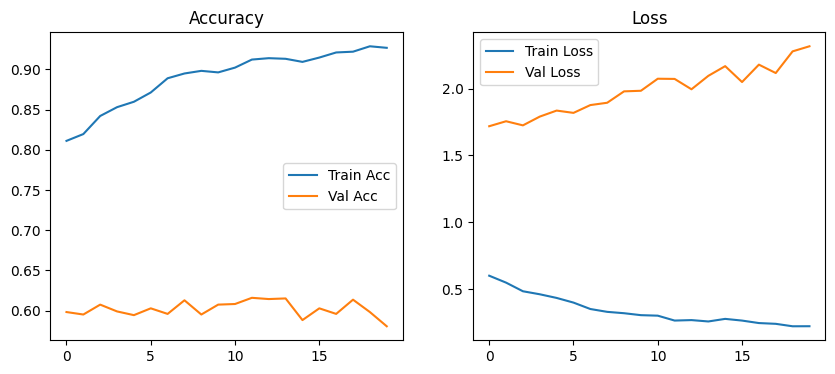

In [52]:
# STEP 8: Plot Accuracy & Loss
# ========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

In [55]:
# ========================
# STEP 9: Evaluate on Validation Set (Precision, Recall, F1)
# ========================
val_gen.reset()
val_preds = model.predict(val_gen)
val_pred_classes = np.argmax(val_preds, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n📊 Classification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step

📊 Classification Report:
                           precision    recall  f1-score   support

                   ADONIS       0.00      0.00      0.00        19
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00        17
           AMERICAN SNOOT       0.00      0.00      0.00        16
                    AN 88       0.07      0.06      0.06        17
                  APPOLLO       0.00      0.00      0.00        14
                    ATALA       0.00      0.00      0.00        23
 BANDED ORANGE HELICONIAN       0.05      0.05      0.05        19
           BANDED PEACOCK       0.00      0.00      0.00        16
            BECKERS WHITE       0.00      0.00      0.00        16
         BLACK HAIRSTREAK       0.00      0.00      0.00        27
              BLUE MORPHO       0.00      0.00      0.00        10
        BLUE SPOTTED CROW       0.00      0.00      0.00        16
           BROWN SIPROETA       0.00      0.00      0.00      

In [54]:
# ========================
# STEP 10: Save the Model
# ========================
model.save("butterfly_cnn_model.h5")
print("✅ Model saved as butterfly_cnn_model.h5")

✅ Model saved as butterfly_cnn_model.h5
